# Application Executor Makespans

In [1]:
from __future__ import annotations

import importlib
import json
import os
import pathlib

import seaborn
import polars
from matplotlib import pyplot as plt

polars.Config.set_tbl_rows(100)

polars.config.Config

In [2]:
def load_tasks(filepath: pathlib.Path) -> polars.DataFrame:
    tasks = []
    with open(filepath) as f:
        for line in f.readlines():
            task_info = json.loads(line)
            execution_info = task_info.pop('execution')
            task_info = {**task_info, **execution_info}
            tasks.append(task_info)

    return polars.DataFrame(tasks)

def get_runtime_from_log(filepath: pathlib.Path) -> float | None:
    with open(filepath) as f:
        for line in f.readlines():
            if (
                '(webs.run) :: Finished workflow' in line
                or '(taps.run) :: Finished app' in line
            ):
                for part in line.split(' '):
                    if part.startswith('runtime='):
                        # split "runtime=XX.XXXs," on = and take second half
                        # then chop off the "s," 
                        return float(part.split('=')[1][:-2])
    return None

def load_data(directory: pathlib.Path) -> polars.DataFrame:
    runs = []

    for tasks_path in directory.glob('**/tasks.json*'):
        app, executor, timestamp = str(tasks_path.relative_to(directory).parent).split('/')
        
        tasks = load_tasks(tasks_path)
        start_time = tasks['submit_time'].min()
        end_time = tasks['received_time'].max()
        
        task_time = end_time - start_time
        app_time = get_runtime_from_log(tasks_path.parent / 'log.txt')

        run_info = {
            'app': app,
            'executor': executor,
            'timestamp': timestamp,
            'type': 'runtime',
            'time': app_time,
        }
        runs.append(run_info)

    return polars.DataFrame(runs)

In [3]:
data = load_data(pathlib.Path('../runs/makespan/'))
data

app,executor,timestamp,type,time
str,str,str,str,f64
"""cholesky""","""ray""","""2024-05-24-21-58-04""","""runtime""",16.68
"""cholesky""","""ray""","""2024-05-24-21-58-52""","""runtime""",15.49
"""cholesky""","""ray""","""2024-05-24-21-58-29""","""runtime""",15.89
"""cholesky""","""taskvine""","""2024-08-11-14-12-14""","""runtime""",35.4
"""cholesky""","""taskvine""","""2024-08-11-14-09-40""","""runtime""",35.32
"""cholesky""","""taskvine""","""2024-08-11-14-14-09""","""runtime""",35.21
"""cholesky""","""parsl""","""2024-05-24-21-55-35""","""runtime""",36.33
"""cholesky""","""parsl""","""2024-05-24-21-54-46""","""runtime""",36.4
"""cholesky""","""parsl""","""2024-05-24-21-56-27""","""runtime""",35.22


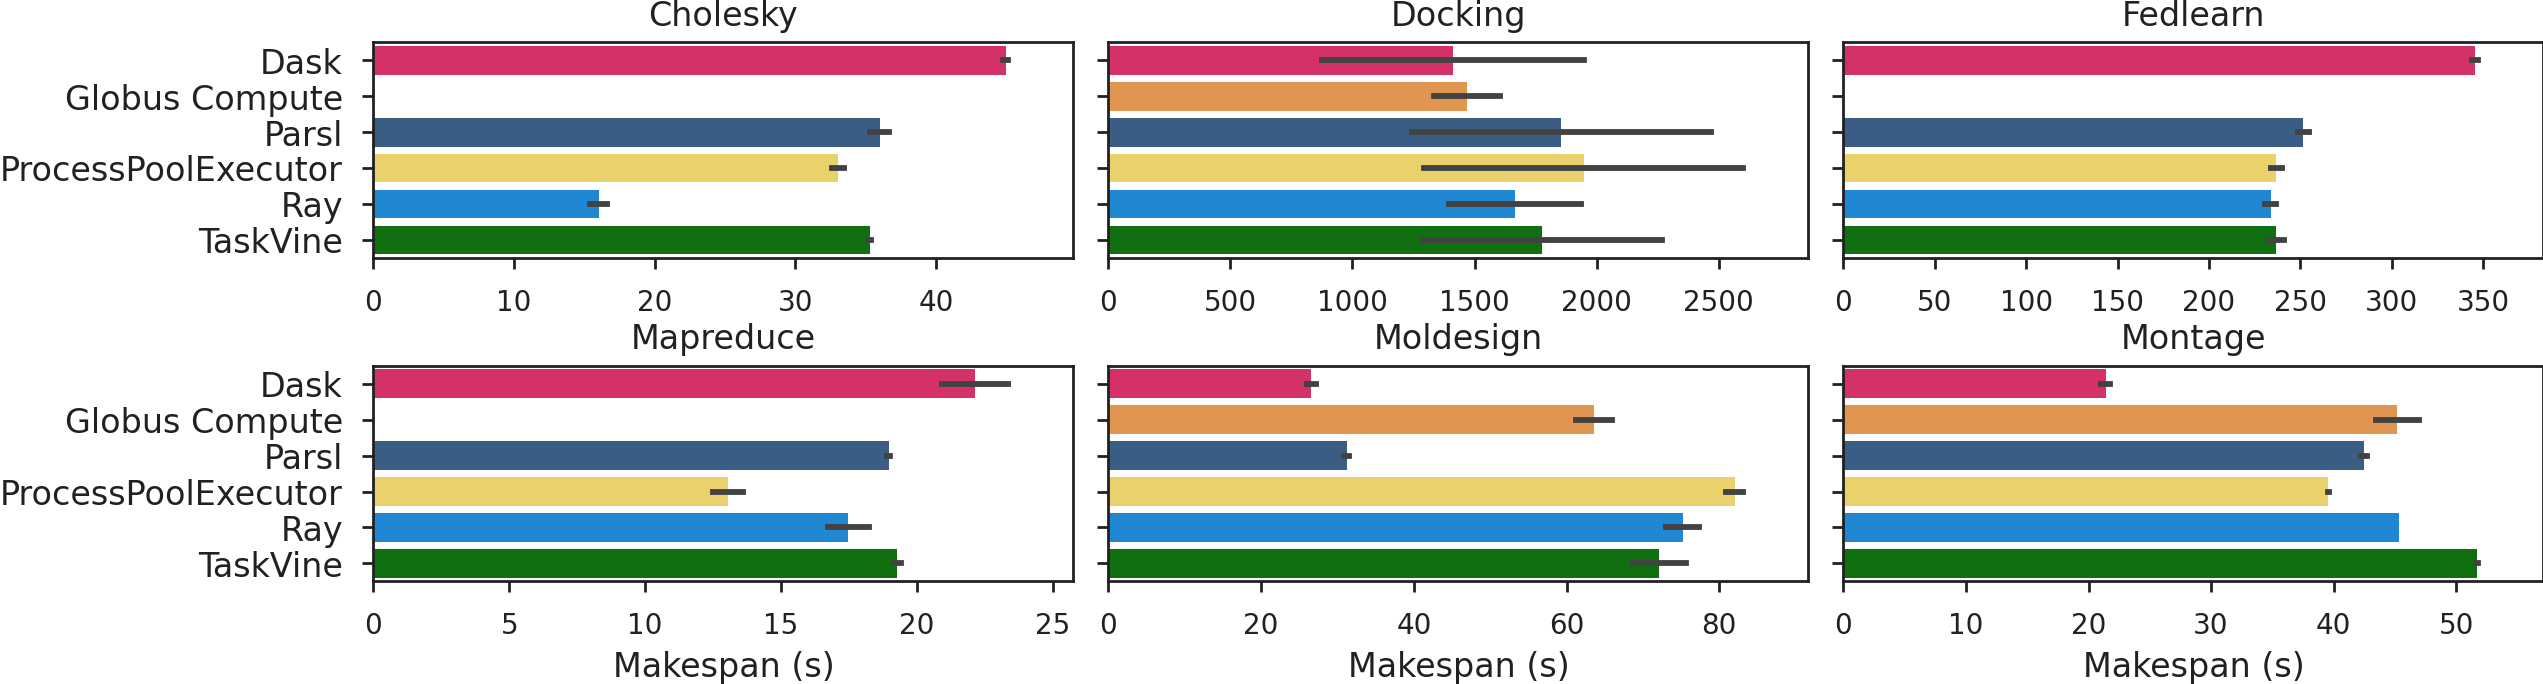

In [5]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, sharey=True)
apps = sorted(set(data['app']))
executors = sorted(set(data['executor']))
names = {
    'dask': 'Dask',
    'globus-compute': 'Globus Compute',
    'parsl': 'Parsl',
    'process-pool': 'ProcessPoolExecutor',
    'ray': 'Ray',
    'taskvine': 'TaskVine',
}
colors = {executor: color['color'] for executor, color in zip(executors, plt.rcParams['axes.prop_cycle'])}
colors = {
    'dask': '#EF1561',
    'globus-compute': '#F89438',
    'parsl': '#2D5D91',
    'process-pool': '#FFDE57',
    'ray': '#028CF0',
    'taskvine': '#008000',
}

for y in range(rows):
    for x in range(cols):
        i = (y * cols) + x
        app = apps[i]

        subdata = data.filter(polars.col('app') == app)
        ax = axes[y][x]
        # Maybe we should print average tasks times: like submit time , execution time, and receive time
        seaborn.barplot(
            ax=ax,
            data=subdata,
            order=executors,
            y='executor',
            x='time',
            hue='executor',
            errorbar='sd',
            orient='h',
            palette=colors,
        )
        ax.set_title(app.title(), pad=3)
        ax.set_ylabel(None)
        ax.tick_params(axis='x', labelsize=5)
        if y == rows - 1:
            ax.set_xlabel('Makespan (s)', labelpad=2)
        else:
            ax.set_xlabel(None)
        ax.set_yticks(range(len(executors)))
        ax.set_yticklabels([names[name] for name in executors])
        l, r = ax.get_xlim()
        ax.set_xlim(l * 1.05, r * 1.05)


plt.subplots_adjust(wspace=0.05, hspace=0.5)
fig.set_size_inches(7, 1.75)
plt.savefig('../figures/app-makespan.pdf', pad_inches=0.05)
plt.savefig('../figures/app-makespan.svg', pad_inches=0.05)